<a href="https://colab.research.google.com/github/eugbyte/nlp-experiment/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM, Embedding, GRU, Bidirectional
import matplotlib.pyplot as plt
import pandas as pds
from sklearn.model_selection import train_test_split
from spacy.lang.en import English
import spacy
import json
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import files
import os
from keras.optimizers import Adam, SGD

# Import files from Google Drive

In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
%cd /content/gdrive/My Drive/Colab Notebooks/

/content/gdrive/My Drive/Colab Notebooks


In [65]:
!ls

 bi-lstm.ipynb				    poetry-generation.ipynb
 Chatbot				    poetry.h5
 Chatbot_squad_v5.ipynb			    robert_frost.txt
'Copy of bi-lstm.ipynb'			    seq2seq.ipynb
'Copy of C4W3_Colab_T5_SQuAD_Model.ipynb'   spa.txt
 glove.6B.50d.txt			    Tutorials


# Constants Configurations

In [66]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
LATENT_DIM = 25
MAX_NUM_WORDS=20000

NUM_SAMPLES = 1000
EPOCHS = 50

# Load in input texts, target texts, and teacher forced texts

In [67]:
# load in the data
input_texts = []
target_texts = []
target_texts_inputs = [] # for teacher forcing, i.e. target_texts offset by 1

In [68]:
i = 0

for line in open('spa.txt'):

  i += 1
  
  # will take too long otherwise
  # also, in datasets, longer sentences ordered at the end
  # the longer the setence, the more the unnecessary paddings
  if i > NUM_SAMPLES:
    break

  if '\t' not in line:
    continue

  input_text, translation = line.split("\t")

  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'
  target_texts_input = '<sos> ' + target_line  # teacher forcing

  input_texts.append(input_line)
  target_texts.append(target_line)
  target_texts_inputs.append(target_texts_input)

In [69]:
print("num samples", len(input_texts))

num samples 1000


In [70]:
print("num samples", len(target_texts))

num samples 1000


# Tokenize the texts

In [71]:
# tokenize the sentences
# you need tokenizers as you have 2 different languages

In [72]:
# the input tokenizer
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS, filters="")
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences =  tokenizer_inputs.texts_to_sequences(input_texts)

In [73]:
word2idx_input = tokenizer_inputs.word_index
print("Len of input word index", len(word2idx_input))

Len of input word index 1547


In [74]:
max_len_input = max(len(s) for s in input_sequences)
print(max_len_input)

8


In [75]:
# tokenize the output
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters="")
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences =  tokenizer_inputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [76]:
word2idx_outputs = tokenizer_outputs.word_index
print("Len of output word index", len(word2idx_input))

Len of output word index 1547


In [77]:
# store number of words for later
# remember to add 1 since indexing starts at 1. <sos> is at index 0

num_words_output = len(word2idx_outputs) + 1

In [78]:
num_words_output

1549

In [79]:
# determine the maximum length output sequence

max_len_target = max(len(s) for s in target_sequences)
print(max_len_target)

7


In [80]:
# pad the input, target, target_inputs sequences

In [81]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input, padding="post")
print(encoder_inputs.shape)
print(encoder_inputs[0])

(1000, 8)
[  1 354   0   0   0   0   0   0]


In [82]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding="post")
print(decoder_inputs.shape)
print(decoder_inputs[0])

(1000, 7)
[  2 355   1   0   0   0   0]


In [83]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding="post")
print(decoder_targets.shape)
print(decoder_targets[0])

(1000, 7)
[354   0   0   0   0   0   0]


# Prepare pre-trained embedding matrix with Glove


In [84]:
# load in pre-trained word vectors

word2vec = {}

print('Loading word vectors...')

file_path = f'glove.6B.{EMBEDDING_DIM}d.txt'
with open(file_path) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [85]:
# Prepare pre-trained embedding matrix
# Instead of a regular embedding matrix, where each cell is a numerical word_token corresponding to word_index, 
# each row is a pre-trained vector

num_words = len(word2idx_outputs) + 1 # word index start from 1 after <sos> token

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

print(embedding_matrix.shape) # words by feture dimensions
print(embedding_matrix[0:2])
print(embedding_matrix[0].shape)

# now the embedding matrix is 3d
for word, i in word2idx_outputs.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word) # get returns None instead of throwing error if key does not exist
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

(1549, 50)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
(50,)


In [86]:
embedding_matrix.shape

(1549, 50)

# One hot encode the target vectors

In [87]:
print(len(input_texts), max_len_target, num_words_output)

1000 7 1549


In [88]:
# one-hot the targets (can't use sparse cross-entropy, since output is more than 2d). We get a sequence

# dimension will be num samples x max_sequence_len x num words. 

one_hot_targets = np.zeros((len(input_texts), max_len_target, num_words_output))  
print(one_hot_targets.shape)

(1000, 7, 1549)


In [89]:
# for every target sequence, for every word_token in that sequence ...
for i, target_sequence in enumerate(target_sequences):
  for t, word_token in enumerate(target_sequence):
    if word_token > 0:     # 0 used for padding
      one_hot_targets[i, t, word_token] = 1

# Build the training model

1.   Note that the training model includes both the encoder RNN layer, followed by the decoder RNN layer
2.   We discard the outputs of the encoder RNN, only saving the state
3.   The decoder RNN reuses this state for teacher forcing.
4.  Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence
5.   Because the training process and inference process (decoding sentences) are quite different, we use different models for both, albeit they all leverage the same inner layers.



## Build the encoder layer


In [ ]:
encoder_inputs_placeholder = Input(shape=(max_len_input, ))

In [90]:
# load pre-trained word embedding into a single LSTM layer
# for pre-training, need to specify the weights
# also need to specify that this first layer should not be retrained since the weights have already been calculated for us
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)  

In [91]:
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True, dropout=0.5)


## Save the thought vector for the decoder layer


In [92]:
# retain the state to pass to the decoder
# c represents the cell state, i.e. weights - you don't keras to generate the weights randomly
# h is the hidden state, i.e. the prediction at the latest time step. h is the same as encoder_outputs here
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [93]:
print(encoder_outputs.shape, h.shape, c.shape)
print(encoder_outputs[0], h[0])

(None, 25) (None, 25) (None, 25)
KerasTensor(type_spec=TensorSpec(shape=(25,), dtype=tf.float32, name=None), name='tf.__operators__.getitem_2/strided_slice:0', description="created by layer 'tf.__operators__.getitem_2'") KerasTensor(type_spec=TensorSpec(shape=(25,), dtype=tf.float32, name=None), name='tf.__operators__.getitem_3/strided_slice:0', description="created by layer 'tf.__operators__.getitem_3'")


## Build the decoder layer

In [94]:
# build the decoder layer
decoder_inputs_placeholder = Input(shape=(max_len_target, ))

In [95]:
decoder_inputs_placeholder.shape

TensorShape([None, 7])

In [96]:
# use new embedding layer since you are using a new language
decoder_embedding = Embedding(num_words_output, LATENT_DIM) # decoder_embedding layer will not use pre-trained word vectors
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)


In [97]:
# since the decoder is a to-many model, we want return-sequences = True
# many sentences are translated to many sentences
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [98]:
# final dense layer for prediction
decoder_dense = Dense(num_words_output, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

## Compile the model

In [99]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [100]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [101]:
encoder_inputs.shape

(1000, 8)

In [102]:
max_len_input

8

In [103]:
decoder_inputs.shape

(1000, 7)

In [104]:
max_len_target

7

In [105]:
r = model.fit([encoder_inputs, decoder_inputs], one_hot_targets, # [english sentences, teacher forced senteces], target sentences
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=0.2)

Epoch 1/50
7/7 [==============================] - 4s 161ms/step - loss: 3.2334 - accuracy: 0.0037 - val_loss: 3.7240 - val_accuracy: 0.0050
Epoch 2/50
7/7 [==============================] - 0s 21ms/step - loss: 3.2237 - accuracy: 0.0153 - val_loss: 3.6994 - val_accuracy: 0.0036
Epoch 3/50
7/7 [==============================] - 0s 22ms/step - loss: 3.1952 - accuracy: 0.0187 - val_loss: 3.6653 - val_accuracy: 0.0000e+00
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 3.0765 - accuracy: 0.0152 - val_loss: 3.6442 - val_accuracy: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 0s 20ms/step - loss: 3.0275 - accuracy: 0.0134 - val_loss: 3.6338 - val_accuracy: 0.0000e+00
Epoch 6/50
7/7 [==============================] - 0s 20ms/step - loss: 2.9423 - accuracy: 0.0124 - val_loss: 3.6292 - val_accuracy: 0.0000e+00
Epoch 7/50
7/7 [==============================] - 0s 22ms/step - loss: 2.9709 - accuracy: 0.0144 - val_loss: 3.6289 - val_accuracy: 0.0000e+00
Epoch 

## Evaluate the model

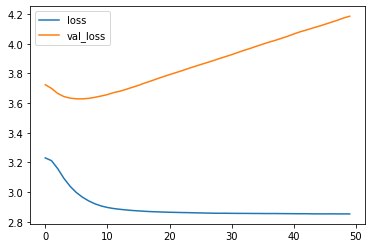

In [106]:
# Plot loss per iteration

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

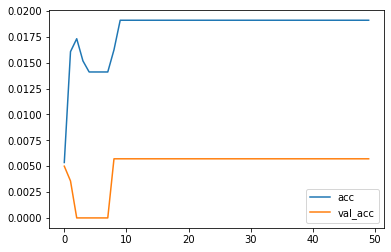

In [107]:
# Plot accuracy per iteration

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

# Create prediction model



1.   Because the training process and inference process (decoding sentences) are quite different, we use different models for both, albeit they all leverage the same inner layers.
2.  An important thing to note is that you are making use of the same dense layer you created earlier - the same trained weights. If you use new layer, then it will have new random weights
3.  Like the training model, the prediction model is made up of encoder and decoder layers

## Theory

1.   Encode the input sequence into state vectors.
2.   Start with a target sequence of size 1 (just the start-of-sequence character).
3.   Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next character.
4.   Sample the next character using these predictions (we simply use argmax).
5.   Append the sampled character to the target sequence
6.   Repeat until we generate the end-of-sequence character or we hit the character limit.

## Encoder Layer for generating initial states

In [108]:
# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

## Create 3 input layers

In [109]:
# 3 input layers
# you want to reuse the hidden state and the cell state

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# predict 1 word at a time, i.e. unigram
decoder_inputs_single = Input(shape=(1,))

## Decoder layer

In [110]:
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [111]:
# recall that you want to set the hidden state, cell state and x from the previous time step
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

## Save the state, which will be updated after each time step

In [112]:
# This allows the sampling model to predict the next sequences of words based on the current word
decoder_states = [h, c]

## Reuse the same trained dense layer from above


In [113]:
### This is the important step where you reuse the same trained weights
decoder_outputs = decoder_dense(decoder_outputs)

## Create the model, but do not compile it

In [114]:
# No need to compile since no training needed
# you are merely using earlier trained weights

# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model([decoder_inputs_single, decoder_state_input_h, decoder_state_input_c], 
                      [decoder_outputs] + decoder_states)

## Map indexes back into real words


In [115]:
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_input.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

# Create the sampling function


In [116]:
word2idx_outputs['<sos>']

2

In [119]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

## Make Predictions


In [122]:
for i in range(4):
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

-
Input: <sos> We know.	Lo sabemos.
Translation: <sos> <sos> <sos> <sos> <sos> <sos> <sos>
-
Input: <sos> Listen.	Escuche.
Translation: <sos> <sos> <sos> <sos> <sos> <sos> <sos>
-
Input: <sos> It's Tom.	Es Tom.
Translation: <sos> <sos> <sos> <sos> <sos> <sos> <sos>
-
Input: <sos> It rained.	Llovió.
Translation: <sos> <sos> <sos> <sos> <sos> <sos> <sos>
